# Setup
Let's begin by importing the modules we'll need.

In [1]:
import pyro
import torch
import pyro.distributions as dist

# 1. Pyro’s distributions (http://docs.pyro.ai/en/stable/distributions.html) :

Pyro provides a wide range of distributions: Normal, Beta, Cauchy, Dirichlet, Gumbel, Poisson,
Pareto, etc.


In [2]:
normal = dist.Normal(0,1)
normal

Normal(loc: 0.0, scale: 1.0)

Samples from the distributions are [Pytorch’s Tensor objects](https://pytorch.org/cppdocs/notes/tensor_creation.html) (i.e. multidimensional arrays).


In [3]:
sample = normal.sample()
sample

tensor(-1.7170)

In [4]:
sample = normal.sample(sample_shape=[3,4,5])
sample

tensor([[[ 0.9471,  0.7462, -1.0435, -0.1748,  1.7270],
         [-0.4117,  2.0106, -1.3406,  1.2701,  1.4021],
         [ 0.2114, -0.4259,  1.2278,  0.2356,  0.7262],
         [ 1.7321, -1.7685,  1.8063,  0.1274, -0.1143]],

        [[ 1.1848, -0.4862, -0.2795,  1.3761, -0.4878],
         [ 1.1506, -0.0127,  1.9091, -0.2464,  2.0348],
         [ 0.2709, -0.9626,  0.6998,  0.0320, -0.2863],
         [ 0.5276, -1.3980,  1.0033, -2.6545, -0.7031]],

        [[ 0.6604, -1.4399,  0.1590, -1.8382, -0.6694],
         [-0.5148,  0.9563,  1.0703,  1.2275, -1.0055],
         [-1.2455, -1.0226, -1.2203,  1.4692, -0.5970],
         [ 1.2720,  0.4942,  0.9431, -0.5395, -0.8014]]])

We can query the dimensionlity of a tensor with the ``shape`` property

In [5]:
sample = normal.sample(sample_shape=[3,4,5])
sample.shape

torch.Size([3, 4, 5])

Operations, like log-likelihood, are defined over tensors.

In [6]:
normal.log_prob(sample)

tensor([[[-1.0690, -1.3813, -1.4370, -1.7593, -0.9425],
         [-1.8471, -1.3139, -2.3172, -1.5089, -2.6078],
         [-1.0348, -1.6561, -0.9194, -0.9220, -2.6581],
         [-0.9404, -1.1605, -1.1146, -0.9406, -0.9602]],

        [[-0.9313, -2.6775, -1.1312, -1.0765, -0.9450],
         [-0.9669, -1.4187, -1.1675, -2.0352, -2.0483],
         [-0.9763, -1.0524, -0.9532, -0.9227, -0.9675],
         [-0.9394, -1.0605, -1.0137, -2.1035, -0.9308]],

        [[-0.9258, -1.2503, -1.5549, -1.1971, -0.9529],
         [-1.1846, -0.9502, -1.8096, -1.0796, -1.0859],
         [-1.7585, -0.9356, -0.9597, -0.9346, -1.5904],
         [-0.9400, -4.8671, -1.2594, -0.9414, -1.1224]]])

In [7]:
torch.sum(normal.log_prob(sample))

tensor(-81.1087)

Multiple distributions can be embedded in single object, as shown in this example, where three Normal distributions with different means and same scale are defined in a single object.

In [8]:
normal = dist.Normal(torch.tensor([1.,2.,3.]),1.)
normal

Normal(loc: torch.Size([3]), scale: torch.Size([3]))

In [9]:
normal.sample()

tensor([0.7861, 2.6170, 1.7676])

In [10]:
normal.log_prob(normal.sample())

tensor([-1.0068, -1.0129, -1.3494])

# 2. Pyro’s model (http://pyro.ai/examples/intro_part_i.html) :


* In Pyro, a probabilistic model is defined as a stochastic function (i.e. every time is run, it returns a new sample).

* Each random variable is associated to a primitive stochastic function using the construct ``pyro.sample(...)``.



### 2.1 A Temperature Model 



As initial running example, we consider the problem of modelling the temperature. We first start with a simple model where temperture is modeled using a random Normal variable.

In [11]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    return temp

print(model())
print(model())

tensor(13.6592)
tensor(14.6975)


See how the model is a stochastic function which returns a different value everytime is invoked. 

### 2.2 A Temperature-Sensor Model

* In Pyro, an stochastic method is defined as a **composition of primitive stochastic functions**.

In the following example, we introduce the presence of a sensor, which is the one which is giving observations about the real temperature. In this case, we assume the sensor provides unbiased measurments of the temperature (i.e. the mean of the sensor's readings are the real temperature) and the error of the sensor's measurements is known.

In [12]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return (temp, sensor)

out1 = model()
out1

(tensor(15.4570), tensor(15.4885))

The above method defines a joint probability distribution:
$$p(sensor, temp) = p(sensor|temp)p(temp)$$

<!--
A graphical description of this model, in terms of probabilistic graphical models, would be as follows:

<img src="slides/Figures/PGM-Tem-Sensor.png" alt="Drawing" style="width: 150px;" >
-->

In this case, we have a simple dependency between the variables. But, as we are in a PPL, dependencies can be expressed in terms of complex deterministic functions (more examples later).

# 3. Pyro’s inference (http://pyro.ai/examples/intro_part_ii.html) :

### Auxiliary inference functions (more details on Day 3)

To make inference on Pyro, we will use a variational inference method, which performs gradient-based optimization to solve the inference problem. More details will be given on Day 3. 

In [13]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, guide, obs, num_steps = 5000, plot = False):
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()

### 3.1  Conditioning on a single observation

Now, we continue with the last model defined in section 2.2, and assume we have a sensor reading and we want to compute the posterior distribution over the real temperature. 


* When defining the model we can introduce observations in a random variable with the keyword ``obs=``.


In [14]:
#The observatons   
obs = {'sensor': torch.tensor(18.0)}

def model(obs):
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1), obs=obs['sensor'])

To make inference in Pyro over a given model we need to define a *guide*, this *guide* has the same signature than its counterpart model. And the guide must provide samples for those variables of the model which are not observed using again the ``pyro.sample`` construct. Guides are also parametrized using Pyro's parameters (``pyro.param``), so the variational inference algorithm will optimize these parameters. All of that will be explained in detail on Day 3.

In [15]:
#The guide
def guide(obs):
    a = pyro.param("mean", torch.tensor(0.0))
    b = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    temp = pyro.sample('temp', dist.Normal(a, b))

Now, we can perform inference making use the previously defined auxiliary functions, ``svi`` and ``guide``, and query the posterior probability distribution: 


$$p(temp | sensor=18)=\frac{p(sensor=18|temp)p(temp)}{\int p(sensor=18|temp)p(temp) dtemp}$$




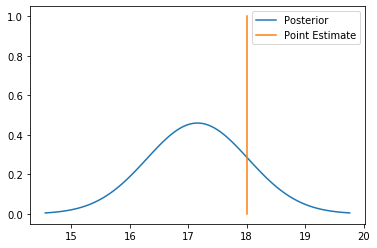

P(Temperature|Sensor=18.0) = 
Normal(loc: 17.15824317932129, scale: 0.8677176237106323)



In [16]:
#Run inference
svi(model,guide,obs,num_steps=3000)


#Plot the results
import numpy as np
import scipy.stats as stats

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 3*scale, mu + 3*scale, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior')
plt.plot([18.0, 18.0],[0., 1.], label='Point Estimate')
plt.legend()
plt.show()

#Print results
print("P(Temperature|Sensor=18.0) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")

Above we can see the result of the inference, and also how the ELBO function is minimized during the variational inference process.

### <span style="color:red">Exercise 1: </span> Change in the precision of the temperature sensor

In the above example, the precision of our temperature sensor is reflected in the scale (or variance) of the Normal distribution of the ``sensor`` variable, which is equal to 1. What happens if we get a more precise temperature sensor which, according ot the specifications of the sensor, has a scale (or variance) equal to 0.5? Modify the code in the ``model`` method and observe the effect in the estimated temperature. 


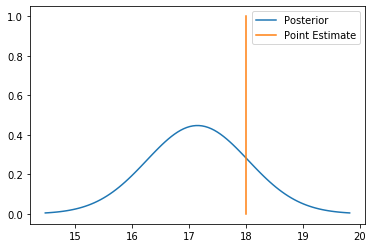

P(Temperature|Sensor=18.0) = 
Normal(loc: 17.147823333740234, scale: 0.8921915292739868)



In [17]:
#The observatons   
obs = {'sensor': torch.tensor(18.0)}

def model(obs):
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
    
    
#Run inference
svi(model,guide,obs,num_steps=3000)

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 3*scale, mu + 3*scale, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior')
plt.plot([18.0, 18.0],[0., 1.], label='Point Estimate')
plt.legend()
plt.show()

#Print results
print("P(Temperature|Sensor=18.0) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")



### 3.2  Learning from a bunch of observations

In this case, we assume we have a bunch of observations about the temperature at different time steps. In this case, following a probabilistic modelling approach, we define a bunch of random variables, one for each observation, using a standard ``for-loo``.

In [18]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(15.0, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])

On the other side, we are not sure about the mean temperature and we want to infer it from the data. For doing that we can follow a *maximum likelihood* approach,

$$ \mu_{t} = \arg\max_\mu \ln p(s_1,\ldots,s_n|\mu) = \arg\max_\mu \prod_i \int_{t_i} p(s_i|t_i)p(t_i|\mu) dt_i $$
where $s_i$ denotes the sensor readings, $t_i$ is the real temperature at time $i$. 

However, with PPLs, we do not have to care about the underlying inference problem. We just define the model and let the PPL's engine make the work for us. So the model is defined as follows, using Pyro's parameters (defined as ``pyro.param``), which are free variables we can optimize. 

In [19]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.param('mean_temp', torch.tensor(15.0))
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])

In [20]:
#Define the guide
def guide(obs):
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))

In [21]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results
print("Estimated Mean Temperature")
print(pyro.param("mean_temp").item())

Estimated Mean Temperature
19.10347557067871


Instead of performing *maximum likelihood* learning, we can perform *Bayesian learning* and treat the unknown as a random variable.

In [22]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])

<!-- The above model can be graphically represented as follows:

<img src="slides/Figures/PGM-Tem-Sensor2.png" alt="Drawing" style="width: 250px;" >
-->



We perform inference over this model. 

In [23]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))

In [24]:
import time
        
#Run inference
start = time.time()
svi(model, guide, obs, num_steps=1000)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")

P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =
Normal(loc: 19.32157325744629, scale: 0.6158466339111328)

9.874096870422363 seconds


Now, the result of the learning is not a *point estimate*, but a *posterior distribution* which captures uncertainty about the estimation.

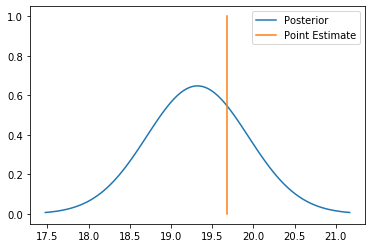

In [25]:
import numpy as np
import scipy.stats as stats

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 3*scale, mu + 3*scale, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior')
point = np.mean(obs['sensor'].numpy())
plt.plot([point, point],[0., 1.], label='Point Estimate')
plt.legend()
plt.show()

### 3.3 The use of ``plate`` construct

In this new example, we will tell Pyro how to exploit conditional independencies and vectorization to make inference much faster. This can be done with the construct ``palte``. With this construct we can indicate the different components of the variables ``sensor`` and ``temp`` are conditionally indepdendent from another components of the variables ``sensor`` and ``temp`` when the variable ``mean_temp`` is known.

In [26]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])

Observe how inference in this model is much faster. 

In [27]:
#Define the guide
def guide(obs_sensor):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))    

In [28]:
#Run inference
start = time.time()
svi(model, guide, obs, num_steps=1000)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")

P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =
Normal(loc: 19.311336517333984, scale: 0.6139826774597168)

2.734002113342285 seconds


### <span style="color:red">Exercise 2: </span>The role of *the number of obserbations* in learning

In this case we just want to llustrate how the number of observations taking into account affects the conclusions of our inferences.

1. What happens if we increase the number of samples?
2. What happens if we decreases the number of samples?

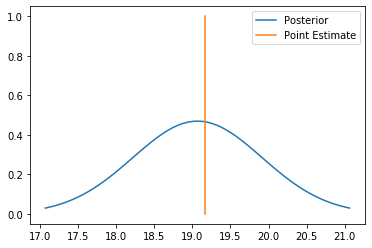

P(Temperature|SensorsMeasurements) = 
Normal(loc: 19.06645965576172, scale: 0.8500266075134277)


In [29]:
#The observatons
mu = 19
samples =10
obs = {'sensor': torch.tensor(np.random.normal(mu, 1.0, samples),dtype=torch.float32)}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2))
    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 2.0), obs=obs['sensor'])

#Run inference
svi(model, guide, obs, num_steps=100)

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 2, mu + 2, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior')
point = np.mean(obs['sensor'].numpy())
plt.plot([point, point],[0., 1.], label='Point Estimate')
plt.legend()
plt.show()
#Print results
print("P(Temperature|SensorsMeasurements) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))


### <span style="color:red">Exercise 3: </span>The role of *prior distributions* in learning

In this case we just want to llustrate how the output of learning depends of the particular prior we introduce in the model. Play with different options and extract conclusions:

1. What happens if we reduce the scale of the ``mean_temp`` variable?
2. What happens if we reduce the scale of the ``mean_temp`` variable and increases the number of samples?
3. What happens if we increase the scale of the ``sensor`` variable?

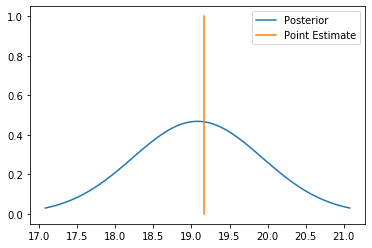

P(Temperature|SensorsMeasurements) = 
Normal(loc: 19.07888412475586, scale: 0.8518422245979309)


In [30]:
#The observatons
mu = 19
samples = 10
obs = {'sensor': torch.tensor(np.random.normal(mu, 1.0, samples),dtype=torch.float32)}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2))
    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 2.0), obs=obs['sensor'])

#Run inference
svi(model, guide, obs, num_steps=100)

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 2, mu + 2, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior')
point = np.mean(obs['sensor'].numpy())
plt.plot([point, point],[0., 1.], label='Point Estimate')
plt.legend()
plt.show()
#Print results
print("P(Temperature|SensorsMeasurements) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))



# 4.  Icecream Shop

Imagine we have an ice-cream shop and we record the ice-cream sales and the average temperature of the day (using a temperature sensor), because we know the temperature influences the sales. We want to precisely find out how temperature affects ice-cream sales. 

<img src="slides/Figures/Ice-cream_shop_-_Florida.jpg" alt="Drawing" style="width: 600px;" >


We assume that the daily sales follows a Poisson distribution, whose mean parameter linearly depends on the real temperature of the day. The coefficients of this linear relationship are modelled as random variables. 


In [31]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

In [32]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))  

In [33]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results    
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))

Posterior Temperature Mean
Normal(loc: 19.32988739013672, scale: 0.629118800163269)

Posterior Alpha
Normal(loc: 19.773204803466797, scale: 1.766861081123352)

Posterior Beta
Normal(loc: 1.5221714973449707, scale: 0.11782679706811905)


### <span style="color:red">Exercise 4: </span>  Introduce Humidity Sensors

Assume we also have a bunch of humidity senor measurements of the real humidity in the air, which is unknown. Then, assume the sales are also linearly influenced by the humidity. Extend the above model in order to integrate all of that.


In [34]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random Normal variable "mean_humidity"

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    
    ## Introduce a random Normal variable to model the coefficient for the humidity "gamma"


    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        #Add the 'humidity' variable and the 'sensor_humidity' variable
        
        #Add the linear dependency of humidity
        sales = pyro.sample('sales', dist.Poisson(????), obs=obs['sales'])

In [35]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']))
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.positive)
    humidity_mean = pyro.sample('humidity_mean', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']), constraint=constraints.positive)
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0), constraint=constraints.positive)
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(1.0), constraint=constraints.positive)
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.positive)
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param('meanH_i', obs['sensor_humidity'][i])
        scaleH_i = pyro.param('scaleH_i', torch.tensor(1.), constraint=constraints.positive)
        humidity = pyro.sample('humidity', dist.Normal(meanH_i, scaleH_i)) 

In [36]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results    
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("meanH").item(), pyro.param("scaleH").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("gamma_mean").item(), pyro.param("gamma_scale").item()))

Posterior Temperature Mean
Normal(loc: 19.306325912475586, scale: 0.6324155330657959)

Posterior Humidity Mean
Normal(loc: 86.38999938964844, scale: 3.0373451709747314)

Posterior Alpha
Normal(loc: 15.159153938293457, scale: 1.910933017730713)

Posterior Beta
Normal(loc: 0.8502270579338074, scale: 0.12438446283340454)

Posterior Gamma
Normal(loc: 0.20352771878242493, scale: 0.027666645124554634)
